In [ ]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

In [37]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = 'c0e252b0-50d3-44e6-bb79-a007a94e3a9e'
resource_group = 'ml_rg'
workspace_name = 'machine_learning1'

ws = Workspace(subscription_id, resource_group, workspace_name)

# print('Workspace name: ' + ws.name, 
#       'Azure region: ' + ws.location, 
#       'Subscription id: ' + ws.subscription_id, 
#       'Resource group: ' + ws.resource_group, sep='\n')

ds1 = Dataset.get_by_name(ws, name='chexpert')
ds2 = Dataset.get_by_name(ws, name='chexpert2')
#ds2.download(target_path='.', overwrite=False)
#print(dataset)


In [38]:
df = ds1.to_pandas_dataframe()
for i, p in enumerate(df["Path"]):
    df["Path"][i] = p[20:]

/tmp/ipykernel_86645/3885918925.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Path"][i] = p[20:]


320
390


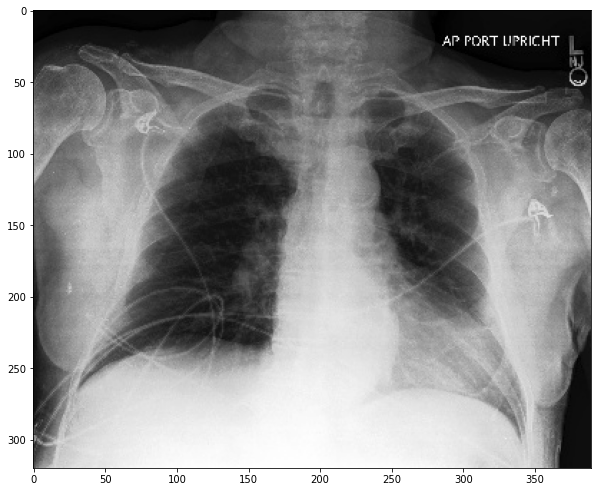

In [39]:
import cv2
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

img0 = 'valid/patient64541/study1/view1_frontal.jpg'
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
    
im=cv2.imread(img0)
print(len(im))      # height
print(len(im[0]))   # width
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()


In [55]:
import glob
import numpy as np
from PIL import Image
from io import StringIO
from torchvision import transforms

class DiseaseDataset(Dataset):
    def __init__(self, img_path, label_matrix):
        self.path = img_path
        self.folder = [p for p in glob.glob(img_path + '/**', recursive=True) if p.endswith('jpg')]
        self.labels = label_matrix
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            # transforms.CenterCrop(320),
            transforms.Resize((320, 320)),
            transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.folder)

    def __getitem__(self, idx):
        img_loc = self.folder[idx]
        image = cv2.imread(img_loc)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        targets = self.labels[idx]

        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

class TrainDiseaseDataset(Dataset):

    def __init__(self, zip_file, img_list, label_matrix):
        self.zip_file = zip_file
        self.folder = img_list
        self.labels = label_matrix
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop(320),
            transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.folder)

    def __getitem__(self, idx):
        img_loc = self.folder[idx][0]
        im_file = self.zip_file.read(img_loc)
        image = cv2.imdecode(np.frombuffer(im_file, np.uint8), 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        targets = self.labels[idx]
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }


In [60]:
import os
import zipfile
import pandas as pd

zip_path = 'CheXpert-v1.0-small.zip'
os.path.isfile(zip_path)
z = zipfile.ZipFile(zip_path)
zip_name_list = z.namelist()

zip_train_list = [x for x in zip_name_list if x.startswith('CheXpert-v1.0-small/train') and x.endswith('.jpg')]

# Train Image Names
sorted_train_list = sorted(zip_train_list, key=lambda f: int(f[33:38]))[1:]

# Train Labels
train_csv = 'CheXpert-v1.0-small/train.csv'
df_train = pd.read_csv(z.open(train_csv))
labels = list(df_train.columns[5:])
label_arr_train = df_train[labels].to_numpy(na_value=0)
label_arr_train = np.where(label_arr_train == -1, 0, label_arr_train)

# Train Data Loader
batch_size = 32
nr_train = len(sorted_train_list)

import random
idx_list = np.arange(nr_train)
random_list= [random.sample(list(idx_list), int(nr_train/2))]

half_train_labels = label_arr_train[tuple(random_list)]
sorted_train_list = np.reshape(np.array(sorted_train_list), (-1, 1))
half_train_img_list = sorted_train_list[tuple(random_list)]

train_data = TrainDiseaseDataset(z, half_train_img_list, half_train_labels)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [61]:
len(sorted_train_list) / len(half_train_img_list)

2.0

In [62]:
# Multi-Label Classification

# Test Labels
labels = list(df.columns[5:])
label_arr_test = df[labels].to_numpy()

# Test Data Loader
batch_size = 5
test_data = DiseaseDataset('valid', label_arr_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [63]:
label_arr_test

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
# ds_model = Dataset.get_by_name(ws, name='densenet121')
# ds_model.download(target_path='.', overwrite=False)

In [64]:
# MODEL
model = torch.load("models/pretrained_densenet121.pth") # to load

#print(model)


In [65]:
num_output_classes = 14

for param in model.parameters():
    param.requires_grad = False
    
new_classifier = torch.nn.Sequential(
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, num_output_classes),
    torch.nn.Sigmoid()
)

model.classifier = new_classifier

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)
model.to(device)
#next(model.parameters()).is_cuda

cuda:0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [66]:
from tqdm import tqdm

n_epoch = 3
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
checkpoint_losses = []
n_total_steps = len(train_loader)

for epoch in range(n_epoch):
    running_loss = 0.0
    with tqdm(train_loader, unit="batch") as tepoch:
        for data in tepoch:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data['image'], data['label']
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            loss.backward()
            optimizer.step()

            tepoch.set_postfix(loss=loss.item())
            # sleep(0.1)
            # print statistics
            # running_loss += loss.item()
            # if (i+1) % (int(n_total_steps/2)) == 0:
            #     checkpoint_loss = torch.tensor(losses).mean().item()
            #     checkpoint_losses.append(checkpoint_loss)
            #     print (f'Epoch [{epoch+1}/{n_epoch}], Step [{i+1}/{n_total_steps}], Loss: {checkpoint_loss:.4f}')

print('Finished Training')
print("Saving model")
torch.save(model, "models/densenet121_valid.pth")
print('Model saved in "models/densenet121_valid.pth"')

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/3491 [00:00<?, ?batch/s]/

Finished Training
Saving model
Model saved in "models/densenet121_valid.pth"


In [ ]:
# n_epoch = 3
# criterion = torch.nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# batch_size = 5

# for epoch in range(n_epoch):
#     running_loss = 0.0
#     for i, (data, label) in enumerate(zip(DataLoader, labelLoader)):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, _ = data
#         inputs, labels = inputs.to(device), label.to(device)
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 100 == 0:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
#             running_loss = 0.0

# print('Finished Training')
# print("Saving model")
# torch.save(model, "models/densenet121_valid.pth")
# print('Model saved in "models/densenet121_valid.pth"')